In [1]:
## required packages for this Chapter
import os, random
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from collections import Counter
import math, scipy
import plfit
from scipy.stats import poisson

sns.set_theme()
%matplotlib inline

# To export to PDF, run:
# jupyter nbconvert --to webpdf --allow-chromium-download assignment_02.ipynb

## Problem 3

In [2]:
def count_isolated_edges(g):
    nodes = g.vs.select(_degree=1)
    isolated_edges = g.subgraph(nodes).es
    return len(isolated_edges)

# def count_isolated_edges(g):
#     no_isolated_edges = 0
#     for v in g.vs:
#         if g.degree(v) == 1:
#             neighbors = g.neighbors(v)
#             if g.degree(neighbors[0]) == 1:
#                 no_isolated_edges += 1
#     return int(no_isolated_edges/2)

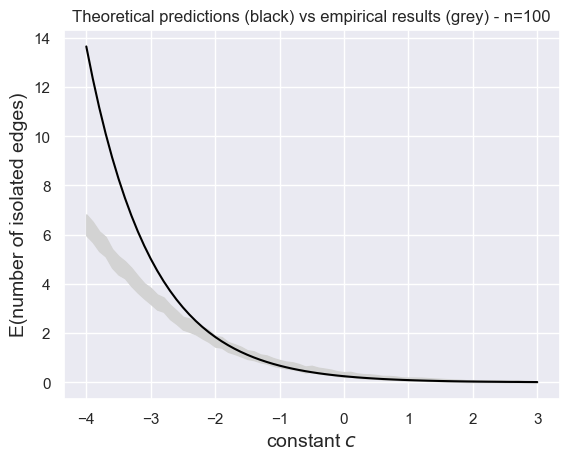

In [3]:
n = 100
REP = 1000 ## repeats
C = np.arange(-4, 3.01,.1) # we can set the range=[-3, 3] here, but we use wider range to see the difference
z = 1.645

# empirical
ic_avg = []
ic_std = []
for c in C:
    x = []
    p = (np.log(n) + np.log(np.log(n)) + c) / (2*n)
    for rep in range(REP):        
        g = ig.Graph.Erdos_Renyi(n=n, p=p)
        n_isolated_edges = count_isolated_edges(g)
        x.append(n_isolated_edges)
    ic_avg.append(np.mean(x))
    ic_std.append(np.std(x))

lower_bound = [(m - s * z / np.sqrt(n)) for m,s in zip(ic_avg, ic_std)] 
upper_bound = [(m + s * z / np.sqrt(n)) for m,s in zip(ic_avg, ic_std)] 

## theoretical
th = [np.exp(-c) / 4 for c in C]

## plot
plt.fill_between(C, lower_bound, upper_bound, color='lightgray')
plt.plot(C, th, color='black')
plt.title(f'Theoretical predictions (black) vs empirical results (grey) - n={n}')
plt.xlabel(r'constant $c$', fontsize=14)
plt.ylabel('E(number of isolated edges)', fontsize=14)
plt.show()

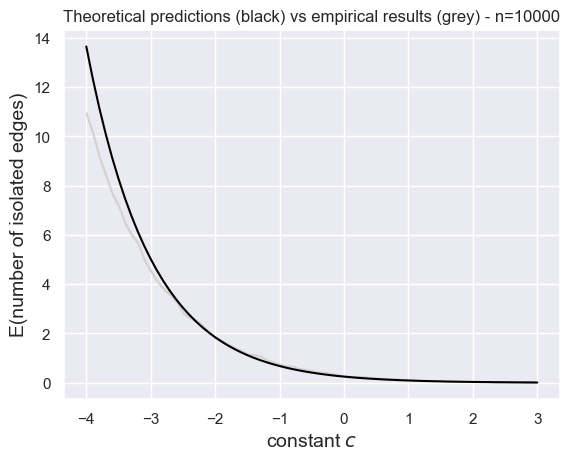

In [4]:
n = 10000
REP = 1000 ## repeats
C = np.arange(-4, 3.01,.1) # we can set the range=[-3, 3] here, but we use wider range to see the difference
z = 1.645

# empirical
ic_avg = []
ic_std = []
for c in C:
    x = []
    p = (np.log(n) + np.log(np.log(n)) + c) / (2*n)
    for rep in range(REP):        
        g = ig.Graph.Erdos_Renyi(n=n, p=p)
        n_isolated_edges = count_isolated_edges(g)
        x.append(n_isolated_edges)
    ic_avg.append(np.mean(x))
    ic_std.append(np.std(x))

lower_bound = [(m - s * z / np.sqrt(n)) for m,s in zip(ic_avg, ic_std)] 
upper_bound = [(m + s * z / np.sqrt(n)) for m,s in zip(ic_avg, ic_std)] 

## theoretical
th = [np.exp(-c) / 4 for c in C]

## plot
plt.fill_between(C, lower_bound, upper_bound, color='lightgray')
plt.plot(C, th, color='black')
plt.title(f'Theoretical predictions (black) vs empirical results (grey) - n={n}')
plt.xlabel(r'constant $c$', fontsize=14)
plt.ylabel('E(number of isolated edges)', fontsize=14)
plt.show()

**Observation:** Plots show the results of number of isolated edges with empirical and theoretical approaches. We can see that:
- Larger number of c will make theoretical results closer to empirical ones.
- Empirical results are closer to theoretical results in larger graphs.

## Problem 6

In [38]:
n = 10000
p = 1.0/4
divisor = scipy.special.comb(n, 2)

g1 = ig.Graph.Erdos_Renyi(n=n, p=p)
g2 = ig.Graph.Erdos_Renyi(n=n, p=p)
g = ig.union([g1, g2])
density = g.ecount() / divisor
print(f'Edges in G1: {g1.ecount()} - Edges in G2: {g2.ecount()} - Edges in union G: {g.ecount()} - Density: {density}')

Edges in G1: 12499981 - Edges in G2: 12500822 - Edges in union G: 21875845 - Density: 0.43756065606560657


**Explanation.**
Graph density is $0.44$ and is not close to $1/2$. The reason is that the union graph includes edges that are either in $g1$ or $g2$. Some edges are common between both. As a result, number of edges of the union graph ($21,875,845$) is less than the summation of edges in $g1$ and $g2$ ($25,000,803$) and therefore has a lower density than $(p + p = 1/2)$. 

## Problem 7

In [5]:
dim = 2
size = 100
nei = 8
REP = 10
P = np.arange(0, 1.01, .1)

gccs = []
alccs = []
for p in P:
    p_gccs = []
    p_alccs = []
    for rep in range(REP):
        g = ig.Graph.Watts_Strogatz(dim, size, nei, p)
        rep_gcc = g.transitivity_undirected()
        rep_alcc = g.transitivity_avglocal_undirected()
        p_gccs.append(rep_gcc)
        p_alccs.append(rep_alcc)
    gcc = np.mean(p_gccs)
    alcc = np.mean(p_alccs)
    gccs.append(gcc)
    alccs.append(alcc)

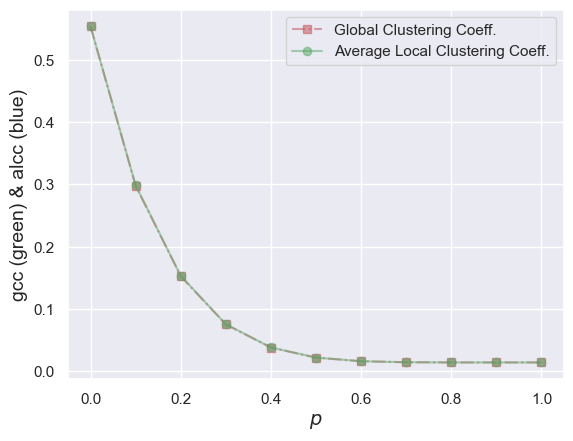

In [9]:
# plot in one figure
plt.plot(P, gccs, color='r', linestyle='-.', alpha=0.5, marker='s', label='Global Clustering Coeff.')
plt.plot(P, alccs, color='g', linestyle='-', alpha=0.5, marker='o', label='Average Local Clustering Coeff.')
plt.xlabel(r'$p$', fontsize=14)
plt.ylabel('gcc (green) & alcc (blue)', fontsize=14)
plt.legend()
plt.show()

# uncomment to plot separate figures
# plt.plot(P, gccs, color='black')
# plt.xlabel(r'$p$', fontsize=14)
# plt.ylabel('gcc', fontsize=14)
# plt.show()

# plt.plot(P, alccs, color='blue')
# plt.xlabel(r'$p$', fontsize=14)
# plt.ylabel('alcc', fontsize=14)
# plt.show()

**Observation:** The two coefficients are pretty close.

## Problem 8

In [20]:
n = 10000
m = 5
g = ig.Graph.Barabasi(n, m, directed=True)

## run plfit and compute K-S statistic (details in the book)
d = g.indegree()
X = plfit.plfit(d)
print(X.plfit())

(9, 1.992375736295442)


Text(31.5, 0.5, 'Kolmogorov-Smirnov statistic')

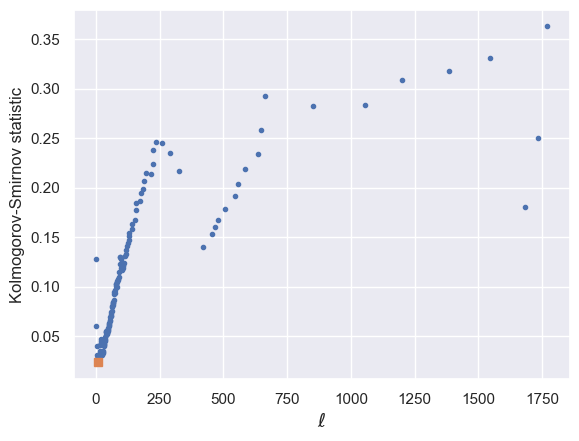

In [21]:
## plot K-S statistics
ax = plt.figure()
ax = X.xminvsks()
ax.set_xlabel(r'$\ell$',fontsize=14)
ax.set_ylabel('Kolmogorov-Smirnov statistic', fontsize=12)
# plt.show()

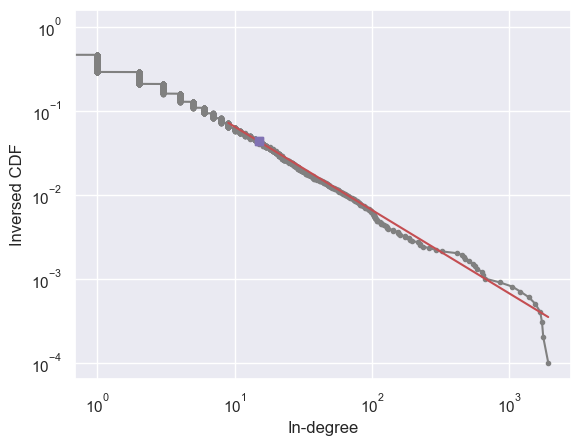

In [22]:
## inverse cdf along with fitted line (as with Figure 2.6 in the book)
fig, ax = plt.subplots()
X.plotcdf(pointcolor='grey', pointmarker='.',zoom=False)
ax.set_xlabel('In-degree', fontsize=12)
ax.set_ylabel('Inversed CDF', fontsize=12)
plt.show()

In [23]:
## K-S test
KS_tst = X.test_pl(niter=100)

p(100) = 0.800


In [43]:
# ## plot K-S statistics vs. exponent (alpha here, gamma' in the book)
# ax = plt.figure(1)
# ax = X.alphavsks()